In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet

In [2]:
df = pd.read_parquet("meow_df.parquet", engine = 'fastparquet')

df.columns

df['time_diff'] = df.seconds_in_bucket - df.seconds_in_bucket_before

df = df.query("""time_id == time_id_before and stock_id == stock_id_before""")

df = df.drop(columns = ['time_id_before', 'seconds_in_bucket_before', 'stock_id_before', 'level_0'])

df['trade'] = (df.price >= df.ask_price1_before).astype(int) - (df.price <= df.bid_price1_before).astype(int)

In [3]:
df['mid'] = (df.ask_price1 + df.bid_price1)/2

df['spread'] = (df.ask_price1 - df.bid_price1)*10000/df.mid

<Axes: ylabel='Frequency'>

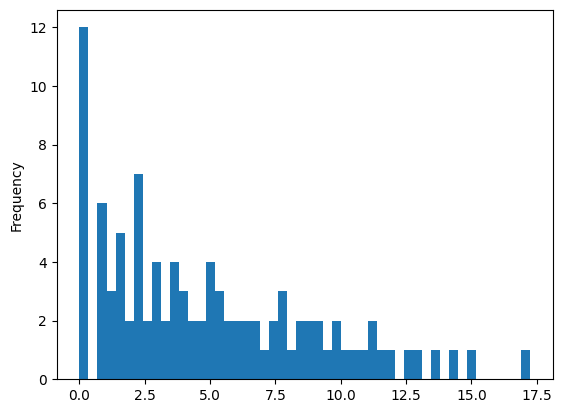

In [4]:
np.log(df.time_diff.value_counts()).plot.hist(bins = 50)

In [5]:
#meow moew

In [80]:
target = pd.read_csv("past_vols.csv",index_col="Unnamed: 0")

df.head()

df_size = df['size']



gb = df.groupby(by=['stock_id', 'time_id']).agg({"size":"sum", "spread": "mean","time_diff":"max"})

target = target.merge(gb.reset_index())

target['sqrt_size'] = np.sqrt(target['size'])
target['timef'] = np.log(target['time_diff'])

<Axes: ylabel='Frequency'>

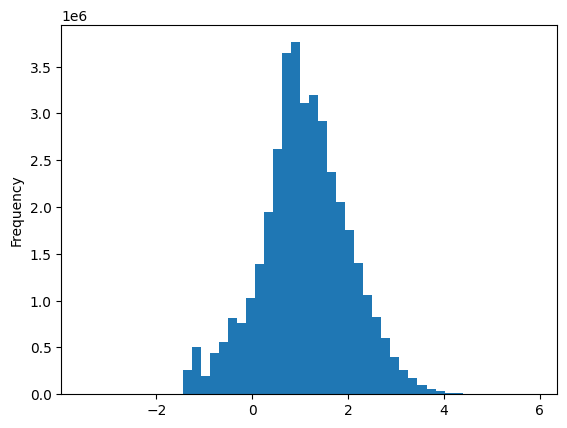

In [81]:
np.log(df.spread).plot.hist(bins = 50)

<Axes: ylabel='Frequency'>

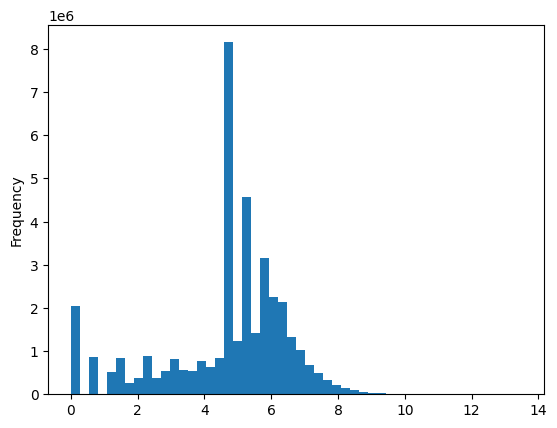

In [82]:
pd.Series(np.log(df['size'])).plot.hist(bins = 50)

<Axes: xlabel='spread', ylabel='sigma'>

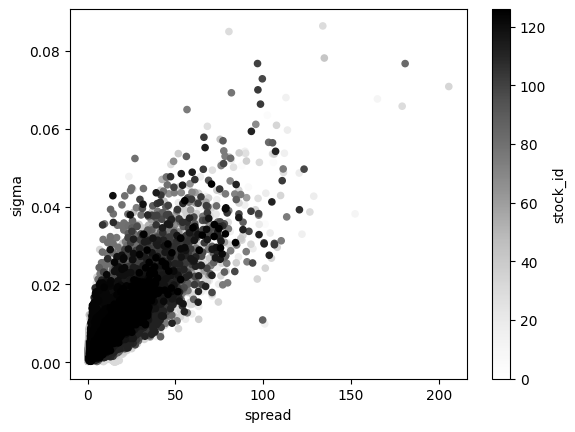

In [83]:
target.plot.scatter(x="spread", y="sigma",c= "stock_id")
#spread very high corr with vol. unsuprising

<Axes: xlabel='sqrt_size', ylabel='sigma'>

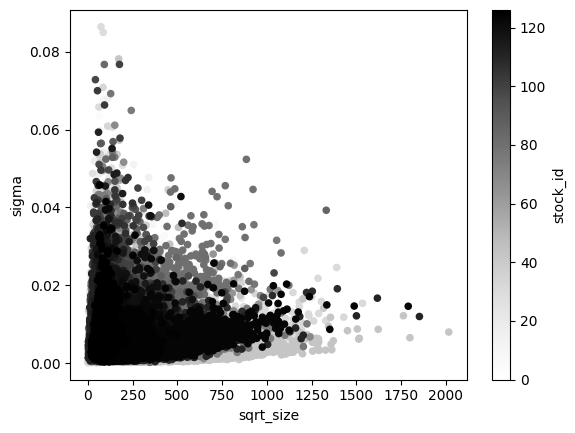

In [84]:
target.plot.scatter(x="sqrt_size", y="sigma",c= "stock_id")

#Size low corr with sigma: prob due to low corr size ~ volume

<Axes: xlabel='timef', ylabel='sigma'>

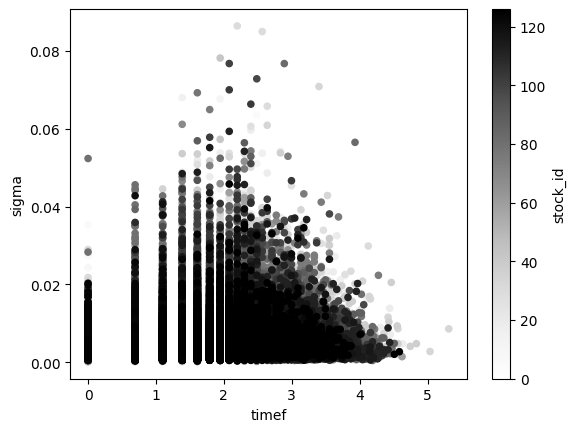

In [85]:
target.plot.scatter(x= "timef", y = "sigma", c="stock_id")

#Hmm very liquid mala sigma, illiquid tez, mid liquid duze zmiany?

In [87]:
target.corr().sigma
#cool

stock_id    -0.020233
time_id     -0.005234
sigma        1.000000
size         0.061231
spread       0.840079
time_diff    0.026514
sqrt_size    0.027341
timef        0.061595
Name: sigma, dtype: float64